In [52]:
import numpy as np
import cv2
import glob
import os
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import alignment.helper
import alignment
%matplotlib inline

def convert_images(img,bg=255):
    a = int(1224*0.5)
    b = a+1224
    left = img.copy().astype(float)
    left[:,a:b] = left[:,:1224]
    left[:,b:] = bg
    left[:,:a] = bg
    right = img.copy().astype(float)
    right[:,a:b] = right[:,1224:]
    right[:,b:] = bg
    right[:,:a] = bg    
    imgs = [left[:,-1::-1],right]
    return imgs
    
def load_images(fname):
    img = cv2.imread(fname)
    greyscaleimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#.astype(float)
    return convert_images(greyscaleimg)
    

In [53]:
allimages = [[],[]]
allintervals = [[],[]]
for i,imfn in enumerate(sorted(glob.glob('/home/mike/Documents/Research/seed_data/calibration/*.tiff'))[:7]):
    print(imfn)
    imgs = load_images(imfn)
    allimages[0].append(imgs[0])
    allimages[1].append(imgs[1])
    allintervals[0].append(i)
    allintervals[1].append(i)

/home/mike/Documents/Research/seed_data/calibration/Basler_a2A2440-98g5mBAS__40446667__20250512_164452590_0000.tiff
/home/mike/Documents/Research/seed_data/calibration/Basler_a2A2440-98g5mBAS__40446667__20250512_164605099_0000.tiff
/home/mike/Documents/Research/seed_data/calibration/Basler_a2A2440-98g5mBAS__40446667__20250512_164718382_0000.tiff
/home/mike/Documents/Research/seed_data/calibration/Basler_a2A2440-98g5mBAS__40446667__20250512_164803041_0000.tiff
/home/mike/Documents/Research/seed_data/calibration/Basler_a2A2440-98g5mBAS__40446667__20250512_164842606_0000.tiff
/home/mike/Documents/Research/seed_data/calibration/Basler_a2A2440-98g5mBAS__40446667__20250512_164925324_0000.tiff
/home/mike/Documents/Research/seed_data/calibration/Basler_a2A2440-98g5mBAS__40446667__20250512_165010275_0000.tiff


In [54]:
#plt.imshow(allimages[0][3])

In [55]:
al = alignment.build_alignment_object(allimages,allintervals,hfov=0.4,usecache=False) #np.rad2deg(0.4)=23 degrees

In [56]:
al.compute_orientation()

Starting first pass...
Starting second pass...


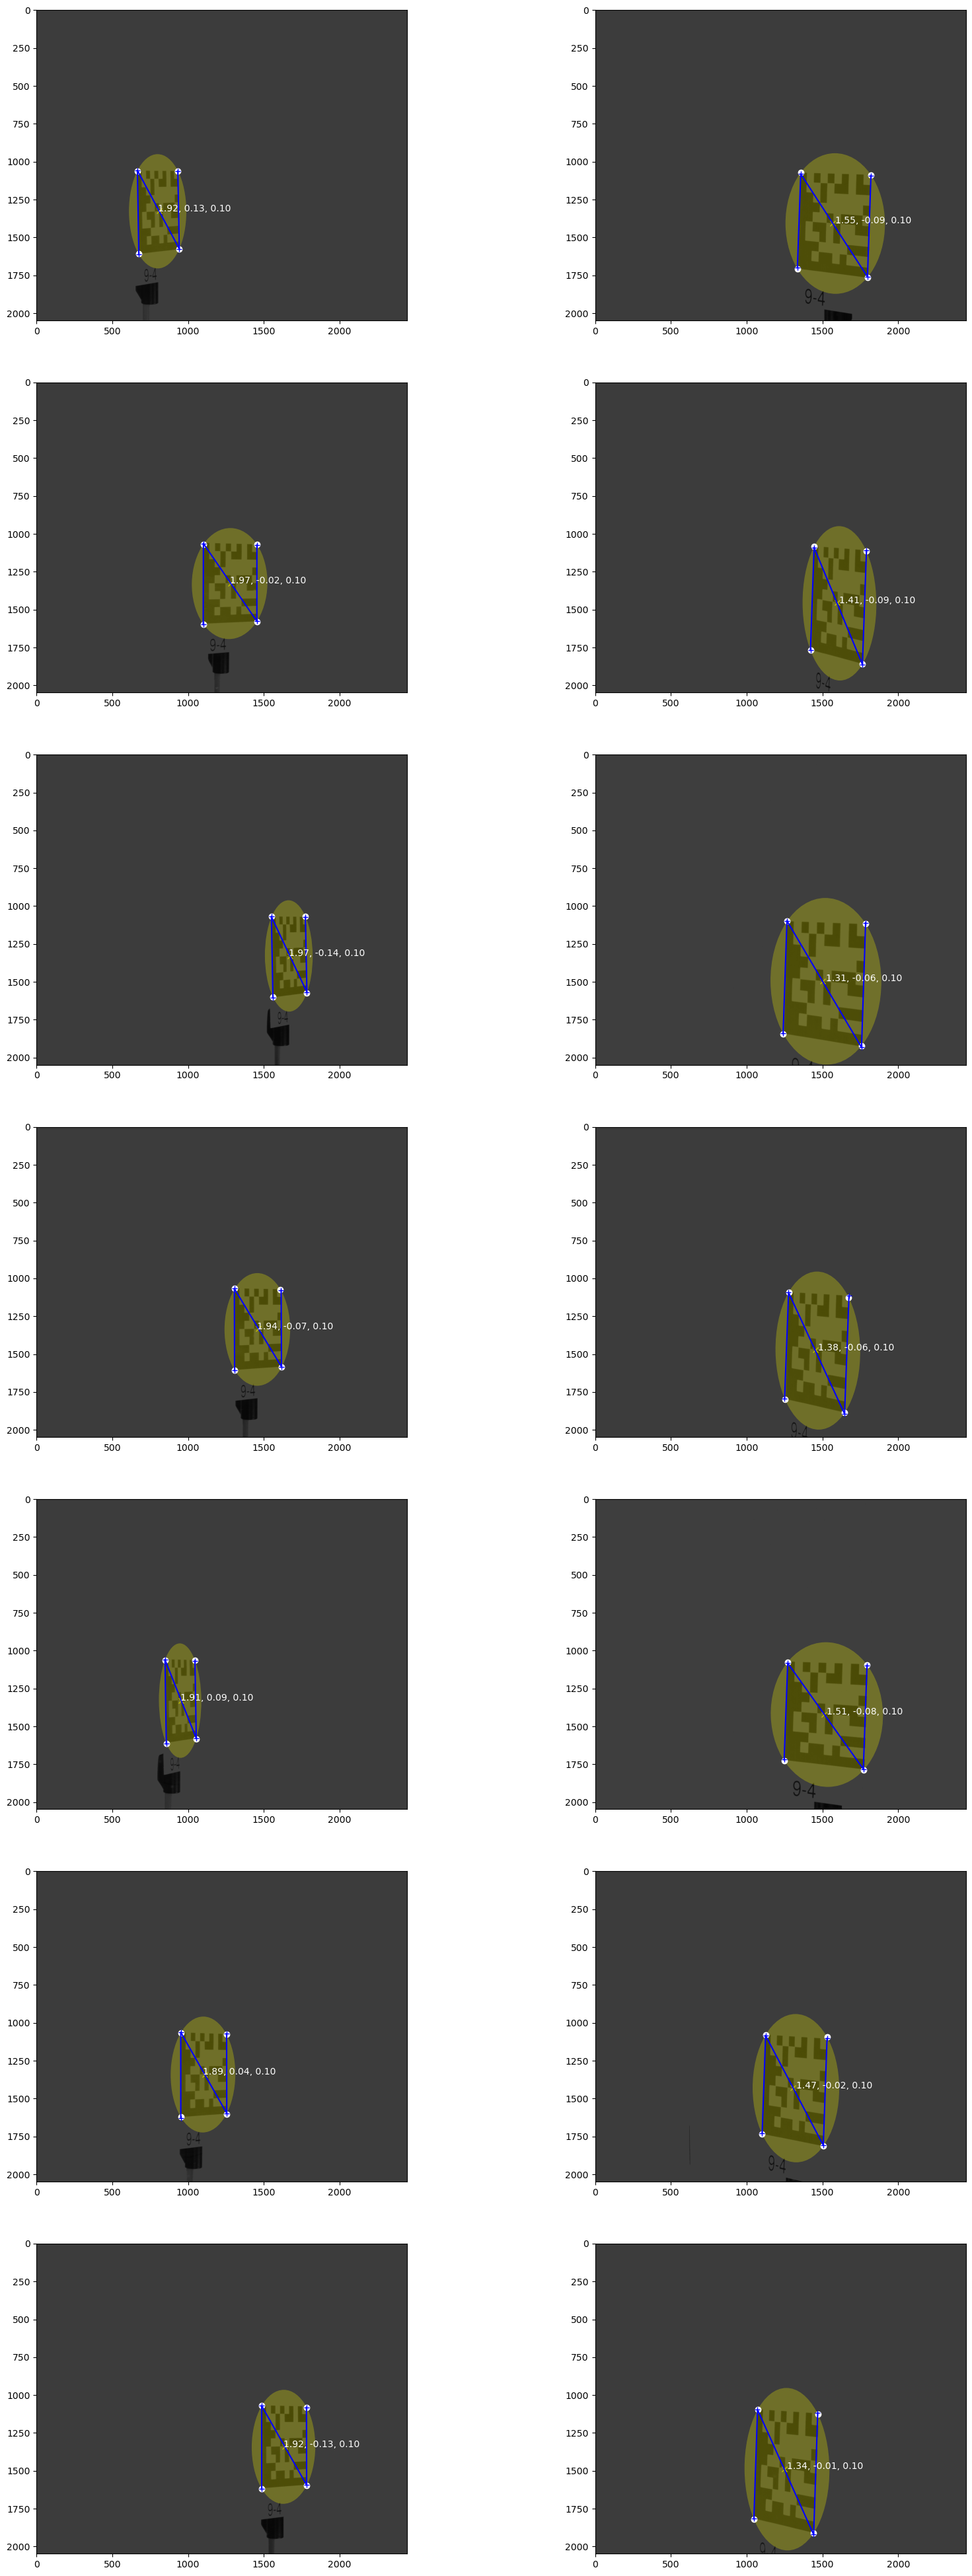

In [57]:
plt.figure(figsize=[20,50])
for i in range(len(allintervals[0])):
    for j in range(len(al.cameras)):
        plt.subplot(len(allintervals[0]),len(al.cameras),i*len(al.cameras)+j+1)
        for photo in al.photos:
            if photo.camera == al.cameras[j]:
                if photo.timeindex == i:                
                    photo.draw()

In [58]:
vertical = np.genfromtxt('/home/mike/Documents/Research/seed_data/vertical.csv',delimiter=',')

In [115]:
left = vertical[:,:2].copy()
left[:,0]+=int(1224*0.5)
left[:,0]=2448-left[:,0]
right = vertical[:,2:].copy()
right[:,0]-=int(1224*0.5)
left,right

(array([[1172., 1702.],
        [1169., 1386.],
        [1171., 1099.],
        [1170.,  806.],
        [1169.,  510.],
        [1169.,  213.]]),
 array([[1171., 1883.],
        [1173., 1489.],
        [1168., 1128.],
        [1167.,  761.],
        [1162.,  393.],
        [1157.,   22.]]))

In [116]:
coords3d, distances = al.get3dpoint(left,right)

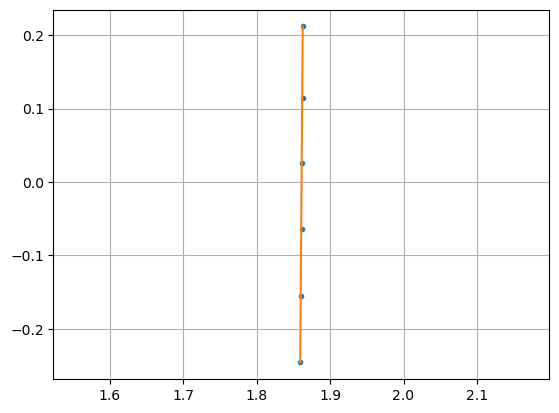

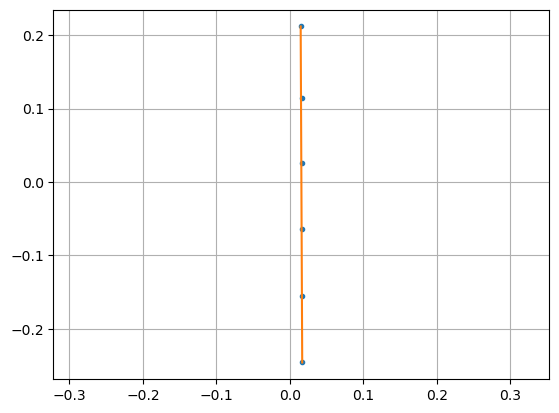

In [117]:
plt.figure()
a = 0
plt.plot(coords3d[:,a],coords3d[:,2],'.')
plt.axis('equal')
plt.plot([coords3d[0,a],coords3d[-1,a]],[coords3d[0,2],coords3d[-1,2]],'-')
plt.grid()

plt.figure()
a = 1
plt.plot(coords3d[:,a],coords3d[:,2],'.')
plt.axis('equal')
plt.plot([coords3d[0,a],coords3d[-1,a]],[coords3d[0,2],coords3d[-1,2]],'-')
plt.grid()

In [62]:
#c. 10 cm apart?

In [63]:
# these distacnes are how mismatched the vectors are when trying to intersect...

In [64]:
distances

array([-0.01072962, -0.00899329, -0.00660391, -0.00458324, -0.0031696 ,
       -0.00135832])

# Tracking the seeds...

In [65]:
def get_seed_2d_coordinates(image_fns,save_debug_images=None,smooth=2, threshold=7, undistort=True):
    """
    
    """
    if save_debug_images is not None:
        plt.figure(figsize=[5,2*len(image_fns)/save_debug_images])
    lastimg = None
    results = []
    for imgindex,fname in enumerate(image_fns):
        img_indexid = int(os.path.split(fname)[-1][-9:-5])
        img = cv2.imread(fname)
        greyscaleimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float)
        if smooth is not None:
            greyscaleimg = ndimage.gaussian_filter(greyscaleimg, sigma=(smooth, smooth), order=0)
        
        if lastimg is not None:
            diff_greyscaleimg = greyscaleimg - lastimg
            diff_imgs = convert_images(diff_greyscaleimg,bg=0)              
            coords = []
            
            for diff_img in diff_imgs:
                coords.append(np.unravel_index(diff_img.argmax(), diff_img.shape))
            results.append([img_indexid,np.max(diff_imgs[0]),np.max(diff_imgs[1]),coords[0],coords[1]])
            if save_debug_images is not None:
                if imgindex%save_debug_images==0:
                    for imgpairi in range(2):
                        plt.subplot(int(1+len(image_fns)/save_debug_images),2,int(2*(imgindex/save_debug_images)+imgpairi+1))
                        plt.imshow(diff_imgs[imgpairi][max(coords[imgpairi][0]-100,0):min(coords[imgpairi][0]+100,2047),max(coords[imgpairi][1]-100,0):min(coords[imgpairi][1]+100,1223)])
                        plt.clim([0,np.max(diff_imgs[imgpairi])])
                        plt.vlines([100,100],[25,125],[75,175],'w')
                        plt.hlines([100,100],[25,125],[75,175],'w')
                        plt.xticks([])
                        plt.yticks([])
                        if imgpairi==0: plt.title("%0.1f %0.1f " % (np.max(diff_imgs[0]),np.max(diff_imgs[1]))+str(coords))
        lastimg = greyscaleimg
    if save_debug_images:
        path_to_data, _ = os.path.split(image_fns[0])
        plt.savefig(os.path.join(path_to_data,'debug.pdf'))
    return results

In [126]:
seed_undistorted_ps = []
seed_original_ps = []
basepath = '/home/mike/Documents/Research/seed_data/250305'
for foldername in ['Afatua_t1']:#,'caryopsis_t1','Gfluitans_t1']:
    pathtodata = os.path.join(basepath,foldername)
    image_fns = sorted(glob.glob(os.path.join(pathtodata,'*.tiff')))
    coords2d = get_seed_2d_coordinates(image_fns)
    break
coords2d = np.array([(c[0],c[1],c[2],c[3][1],c[3][0],c[4][1],c[4][0]) for c in coords2d]) #convert to a easy array


In [127]:
coords2d

array([[7.40000000e+01, 2.66835439e+00, 2.17605590e+00, 9.35000000e+02,
        0.00000000e+00, 6.17000000e+02, 6.80000000e+02],
       [7.50000000e+01, 3.45118628e+00, 2.39522520e+00, 9.41000000e+02,
        1.20000000e+01, 6.16000000e+02, 6.66000000e+02],
       [7.60000000e+01, 3.39582537e+00, 2.43089775e+00, 9.48000000e+02,
        3.40000000e+01, 7.08000000e+02, 2.88000000e+02],
       [7.70000000e+01, 7.27296657e+00, 2.24507911e+00, 1.31300000e+03,
        0.00000000e+00, 6.32000000e+02, 1.49100000e+03],
       [7.80000000e+01, 9.24068941e+01, 1.74149579e+00, 1.30200000e+03,
        6.20000000e+01, 6.52000000e+02, 3.49000000e+02],
       [7.90000000e+01, 9.17700464e+01, 2.30432243e+00, 1.30300000e+03,
        1.36000000e+02, 8.27000000e+02, 2.55000000e+02],
       [8.00000000e+01, 5.89603766e+01, 9.12769398e+01, 1.30500000e+03,
        2.12000000e+02, 1.17800000e+03, 0.00000000e+00],
       [8.10000000e+01, 6.38250292e+01, 1.01519775e+02, 1.30800000e+03,
        2.95000000e+02, 1

In [153]:
seedpath = []
threshold = 7
coords2d = coords2d[(coords2d[:,1]>threshold) & (coords2d[:,2]>threshold)]
coords3d, dists = al.get3dpoint(coords2d[:,3:5],coords2d[:,5:7])

In [155]:
np.max(np.abs(dists)) #this is how far apart the vectors are

0.01114985068814149

In [156]:
coords3d

array([[ 1.88063814, -0.02421245, -0.24642444],
       [ 1.88064626, -0.02587051, -0.22430513],
       [ 1.88071919, -0.02564428, -0.19940949],
       [ 1.88060034, -0.02520367, -0.17396418],
       [ 1.88006511, -0.0244686 , -0.14847416],
       [ 1.88032156, -0.02647681, -0.12390073],
       [ 1.8794181 , -0.0256181 , -0.09920806],
       [ 1.88051751, -0.02535851, -0.0747025 ],
       [ 1.87970471, -0.02416172, -0.05099741],
       [ 1.88004889, -0.024534  , -0.02684906],
       [ 1.88129342, -0.02584913, -0.00298003],
       [ 1.88167571, -0.02562139,  0.02077874],
       [ 1.88194843, -0.02635519,  0.04458061],
       [ 1.88199242, -0.02648073,  0.06897361],
       [ 1.88234418, -0.02622475,  0.09336749],
       [ 1.88218028, -0.02597372,  0.11922235],
       [ 1.88260763, -0.02641398,  0.14444354],
       [ 1.88284327, -0.0271174 ,  0.16995354],
       [ 1.88374672, -0.02794638,  0.19551794],
       [ 1.88575886, -0.02863329,  0.22117099],
       [ 1.88399638, -0.0285313 ,  0.244

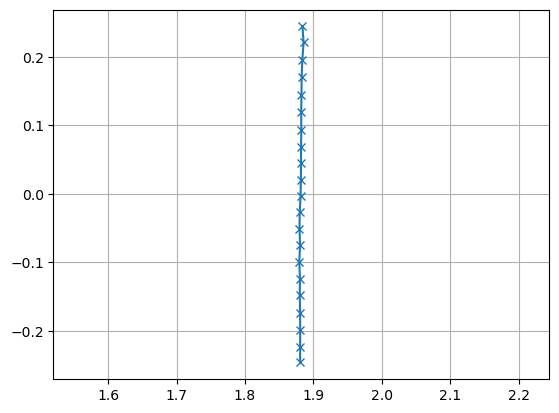

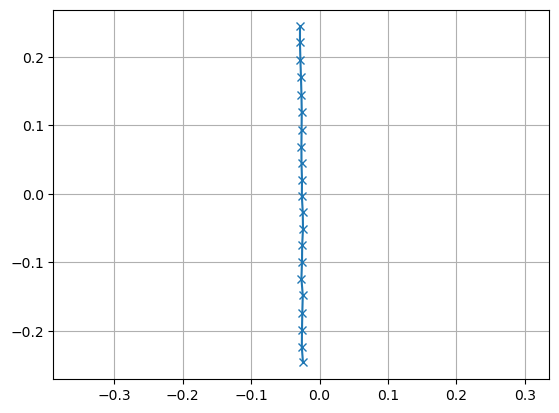

In [159]:
plt.figure()
plt.plot(coords3d[:,0],coords3d[:,2],'-x')
plt.axis('equal')
plt.grid()
plt.figure()
plt.plot(coords3d[:,1],coords3d[:,2],'-x')
plt.axis('equal')
plt.grid()